In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

In [24]:
# Загрузка данных
data = pd.read_csv("famcs_students.csv")

# Заданные бинарные колонки
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

def binarize(col):
    mapping = {
        "Да": 1, "Нет": 0,
        "Бюджет": 1, "Платная": 0,
        "Программирование": 1, "Математика": 0
    }
    return col.map(mapping)

for col in binary_cols:
    data[col] = binarize(data[col])


# Целевая переменная
N = 14
y_col = binary_cols[N % 8]  # N % 8 = 6 => 'study_form'
y = data[y_col]

# Признаки
feature_cols = [col for col in binary_cols if col != y_col]
X = data[feature_cols].astype(int)

# Разделение на train (70%), val (15%), test (15%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42, stratify=y_train_val) 

In [ ]:
'''
Тривиальный классификатор (Baseline):
- Находит наиболее частый класс в обучающих данных (обычно 1).
- Всегда возвращает этот класс для любого объекта.
'''

In [36]:
class TrivialClassifier:
    def fit(self, y):
        counts = y.value_counts()
        self.most_common = counts.idxmax()
        self.p1 = counts[self.most_common] / len(y)  
    
    def predict(self, X):
        return np.full(len(X), self.most_common)

    def predict_proba(self, X):
        return np.full(len(X), self.p1)

trivial_clf = TrivialClassifier()
trivial_clf.fit(y_train)
y_pred_trivial = trivial_clf.predict(X_test)

In [ ]:
'''
Наивный байесовский классификатор:
𝑃(𝑦∣𝑥)=(𝑃(𝑥∣𝑦)𝑃(𝑦)) / 𝑃(𝑥)

Он предполагает, что все признаки независимы друг от друга, следовательно вероятности перемножаются.

Алгоритм:
- Считает, как часто встречается класс (P(y)).
- Для каждого бинарного признака оценивает:
    P(x_i = 1 | y = 0)
    P(x_i = 1 | y = 1)

- Перемножает вероятности.
- Выбирает класс с максимальным 𝑃(𝑦∣𝑥).
'''

In [37]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_probs = {}
        self.feature_probs = {}
        
        for c in self.classes:
            X_c = X[y==c]
            self.class_probs[c] = len(X_c) / len(y)
            self.feature_probs[c] = {}
            for col in X.columns:
                p = (X_c[col].sum() + 1) / (len(X_c) + 2)
                self.feature_probs[c][col] = p
    
    def predict_proba(self, X):
        probs = []
        for _, row in X.iterrows():
            class_scores = {}
            for c in self.classes:
                log_prob = np.log(self.class_probs[c])
                for col in X.columns:
                    p = self.feature_probs[c][col]
                    log_prob += np.log(p if row[col]==1 else (1-p))
                class_scores[c] = np.exp(log_prob)
            total = sum(class_scores.values())
            probs.append(class_scores[1] / total)
        return np.array(probs)

    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)


nb_clf = NaiveBayes()
nb_clf.fit(X_train, y_train)
y_pred_nb = nb_clf.predict(X_test)

In [ ]:
'''
K-ближайших соседей:
Чтобы классифицировать точку, модель смотрит на k ближайших объектов из обучающей выборки.

Алгоритм:
- Вычислить расстояние от нового объекта до всех объектов в train.
- Выбрать k объектов с минимальной дистанцией.
- Посмотреть, какой класс встречается чаще среди этих k.
- Выдать этот класс.
'''

In [38]:
class KNN:
    def __init__(self, k=3):
        self.k = k
    def fit(self, X, y):
        self.X_train = X.values
        self.y_train = y.values
    def predict_proba(self, X):
        X = X.values
        probas = []
        for x in X:
            distances = np.sum(np.abs(self.X_train - x), axis=1)
            nearest_idx = np.argsort(distances)[:self.k]
            nearest_labels = self.y_train[nearest_idx]
            probas.append(nearest_labels.mean())  # доля единичек
        return np.array(probas)
    def predict(self, X):
        return (self.predict_proba(X) >= 0.5).astype(int)


# Подбор оптимального k на валидационной выборке
best_k = 1
best_acc = 0
for k in range(1, 21):
    knn_clf = KNN(k=k)
    knn_clf.fit(X_train, y_train)
    y_val_pred = knn_clf.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    if acc > best_acc:
        best_acc = acc
        best_k = k

# Итоговая модель kNN
knn_clf = KNN(k=best_k)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

In [ ]:
'''
Логистическая регрессия 
Идея

Это линейная модель, которая пытается аппроксимировать вероятность класса 1:

𝑃(𝑦=1∣𝑥)=𝜎(𝑤^𝑇𝑥+𝑏), где σ — сигмоида:
𝜎(𝑧)=1 / (1+𝑒^(−𝑧))

Алгоритм:
- Инициализируются веса.
- Используется градиентный спуск, чтобы минимизировать логистическую потерю:
    𝐿𝑜𝑠𝑠=−[𝑦log⁡𝑝+(1−𝑦)log(1−𝑝)]
- После обучения для каждого объекта получаем вероятность класса 1.
- Затем применяется порог классификации (threshold), например 0.65.
    Если p ≥ threshold → класс 1
    Иначе → класс 0
'''

In [28]:
class LogisticRegression:
    def __init__(self, lr=0.1, n_iter=1000):
        self.lr = lr
        self.n_iter = n_iter
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def fit(self, X, y):
        X = np.hstack([np.ones((X.shape[0],1)), X.values])
        y = y.values
        self.weights = np.zeros(X.shape[1])
        for _ in range(self.n_iter):
            z = X.dot(self.weights)
            y_pred = self.sigmoid(z)
            gradient = X.T.dot(y_pred - y) / len(y)
            self.weights -= self.lr * gradient
    def predict_proba(self, X):
        X = np.hstack([np.ones((X.shape[0],1)), X.values])
        return self.sigmoid(X.dot(self.weights))
    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

# Подбор порога по F1 на валидации
from sklearn.metrics import f1_score, precision_score, recall_score

lr_clf = LogisticRegression(lr=0.1, n_iter=5000)
lr_clf.fit(X_train, y_train)
probs_val = lr_clf.predict_proba(X_val)

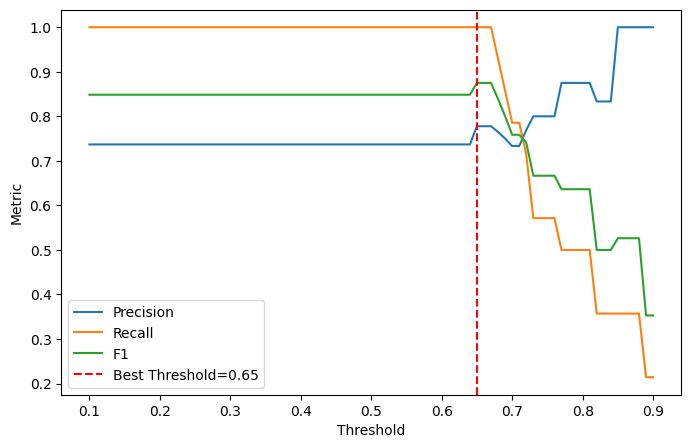

In [29]:
thresholds = np.linspace(0.1, 0.9, 81)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    preds = (probs_val >= t).astype(int)
    f1_scores.append(f1_score(y_val, preds))
    precisions.append(precision_score(y_val, preds))
    recalls.append(recall_score(y_val, preds))

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1_scores, label='F1')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold={best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Metric')
plt.legend()
plt.show()

In [ ]:
'''
Ключевые наблюдения по графику:
1. При низких порогах (ближе к 0.1–0.6) recall очень высокий (≈1.0), а precision средний (~0.72–0.75).
При низком пороге модель помечает большинство объектов как «положительные», поэтому находит почти всех реальных положительных (высокий recall), 
но среди предсказанных положительных много ложноположительных => precision невысокий.
2. По мере увеличения порога recall падает, precision растёт. В области ~0.65 виден «перелом»: 
recall начинает быстро падать, precision немного растёт, следовательно, чем строже порог, тем больше теряется recall, но precision улучшается.
3. Кривая F1 имеет максимум примерно в районе threshold = 0.65 (на графике это красная пунктирная линия). 
F1 = 2·(precision·recall)/(precision+recall) — это гармоническое среднее, оно даёт сбалансированную точку между precision и recall. 
Выбранный порог 0.65 оптимизирует именно F1 на валидации.

Практический вывод: порог 0.65 — разумный компромисс для задач, где важны и precision, и recall в равной степени. 
Но если в задаче важнее, скажем, минимизировать FN (т.е. нужен максимально высокий recall), то стоит выбрать порог левее (меньше), 
а если важнее не допускать FP — порог правее.
'''

In [30]:
# Итоговые предсказания
y_pred_lr = lr_clf.predict(X_test, threshold=best_threshold)

In [39]:
def evaluate_model(model, X_test, y_true, y_pred, name):
    print(f"=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))

    # вероятности положительного класса
    y_proba = model.predict_proba(X_test)

    roc = roc_auc_score(y_true, y_proba)
    print("ROC-AUC:", roc)

    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\n")

evaluate_model(trivial_clf, X_test, y_test, y_pred_trivial, "Trivial Classifier")
evaluate_model(nb_clf, X_test, y_test, y_pred_nb, "Naive Bayes")
evaluate_model(knn_clf, X_test, y_test, y_pred_knn, f"KNN (k={best_k})")
evaluate_model(lr_clf, X_test, y_test, y_pred_lr, f"Logistic Regression (threshold={best_threshold:.2f})")

=== Trivial Classifier ===
Accuracy: 0.75
Precision: 0.75
Recall: 1.0
ROC-AUC: 0.5
Confusion Matrix:
 [[ 0  5]
 [ 0 15]]


=== Naive Bayes ===
Accuracy: 0.75
Precision: 0.75
Recall: 1.0
ROC-AUC: 0.6066666666666667
Confusion Matrix:
 [[ 0  5]
 [ 0 15]]


=== KNN (k=2) ===
Accuracy: 0.75
Precision: 0.7777777777777778
Recall: 0.9333333333333333
ROC-AUC: 0.5
Confusion Matrix:
 [[ 1  4]
 [ 1 14]]


=== Logistic Regression (threshold=0.65) ===
Accuracy: 0.6
Precision: 0.7058823529411765
Recall: 0.8
ROC-AUC: 0.5533333333333333
Confusion Matrix:
 [[ 0  5]
 [ 3 12]]




In [ ]:
'''
A) Trivial Classifier
Матрица: TN=0, FP=5, FN=0, TP=15. Модель предсказывает всегда положительный класс (все объекты — positive).
Отсюда recall = TP/(TP+FN) = 15/15 = 1.0 (все реальные положительные найдены); precision = 15/(15+5)=0.75.
Accuracy = (TP+TN)/total = 15/20 = 0.75.
Это тривиальный классификатор «всегда выдаёт наиболее частый класс» — судя по всему наиболее частый класс в train/val/test — положительный. 
ROC-AUC = 0.5 → модель не лучше случайного угадывания

B) Naive Bayes
Результаты совпадают с тривиальным классификатором: NB предсказывает всегда положительный.
Но даёт не одинаковые вероятности, а разные, т.к. ROC-AUC > 0.5
Это значит, что модель кое-как различает классы по вероятностям, хотя финальные бинарные предсказания не дают заметного улучшения.

C) KNN (k=5)
Матрица: TN=1, FP=4, FN=1, TP=14. KNN дал реальную классификацию (не вырожденную), и показывает наилучшие показатели среди моделей:
Accuracy 0.75 
Precision ≈ 0.7777777777777778 — хорошее соотношение среди предсказанных «+».
Recall ≈ 0.9333 — модель почти не пропускает положительные примеры.

D) Logistic Regression (threshold=0.65)
Матрица: TN=0, FP=5, FN=3, TP=12.
Precision ≈ 0.706 — средне; Recall = 0.8 — тоже средне; но accuracy = 0.6 — хуже KNN и baseline.
Logistic Regression выглядит хуже KNN — в текущей версии либо она недостаточно обучилась (градиентный спуск не сошёлся), 
либо входные признаки (в бинарном виде) не дают линейного разделения.
'''